In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score
)

In [15]:
df = pd.read_csv("../Data/final_engineered_features.csv")
df = df[df['Product Type'] == 'Food/Cosmetics'] #filtering for food products

# Keep only companies with at least one recall
company_with_recall = df.groupby("Legal Name")['recalled_bool'].sum()
companies_to_keep = company_with_recall[company_with_recall > 0].index
df = df[df['Legal Name'].isin(companies_to_keep)].copy()

# Frequency encode 'City'
city_freq_map = df['City'].value_counts().to_dict()
df['City_freq'] = df['City'].map(city_freq_map)

# Drop non-relevant columns
df = df.drop(['classification_flag','Legal Name','City','Zip','FEI Number','Additional Details','FMD-145 Date','Inspection ID','Inspection End Date'], axis=1) 

# One-hot encoding categorical variables
categorical_cols = ['Classification', 'Project Area', 'Product Type', 'State', 'Country/Area', 'inspection_season'] 
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True, dtype=int) 
df['Posted Citations'] = df['Posted Citations'].notnull().astype(int) #converting Posted Citations to binary



# row count
print(f"Row count: {df.shape[0]}", 'recall bool 0:', df['recalled_bool'].value_counts()[0], 'recall bool 1:', df['recalled_bool'].value_counts()[1])

# random rows
df.sample(5)

Row count: 18287 recall bool 0: 2969 recall bool 1: 15318


/var/folders/nt/9z_y1zvs4fv44k33p7cff_cc0000gp/T/ipykernel_40844/587033674.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../Data/final_engineered_features.csv")


,Fiscal Year,Posted Citations,recalled_bool,inspection_year,inspection_month,inspection_dayofweek,inspection_quarter,week_of_year,days_since_last_inspection,City_freq,...,State_Virginia,State_Washington,State_West Virginia,State_Wisconsin,State_Wyoming,Country/Area_France,Country/Area_United States,inspection_season_Spring,inspection_season_Summer,inspection_season_Winter
128533,2013,1,1,2013,9,3,3,39,1540.0,5,...,0,0,0,0,0,0,1,0,0,0
215808,2016,1,1,2016,7,4,3,30,0.0,37,...,0,0,0,0,0,0,1,0,1,0
248756,2013,1,1,2013,7,4,3,28,491.0,7,...,0,0,0,0,0,0,1,0,1,0
27426,2011,1,1,2010,10,3,4,41,0.0,75,...,0,0,0,0,0,0,1,0,0,0
110279,2025,1,1,2025,3,0,1,12,964.0,74,...,0,0,0,0,0,0,1,1,0,0


Code for final model selection using cross validation
1. hyperparameter tuning for Random Forest and SVM done using GridSearchCV
2. class weight is balanced since the data is imbalanced, leaning toward not recalled

We are testing 4 different models:
1. A dummy model where the most frequent class is always predicted is used as the baseline
2. An initial simple model of logistic regression
3. Random forest classifier
4. SVM

Training Dummy...


/Users/kjamshad/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kjamshad/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kjamshad/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

<Figure size 800x600 with 0 Axes>

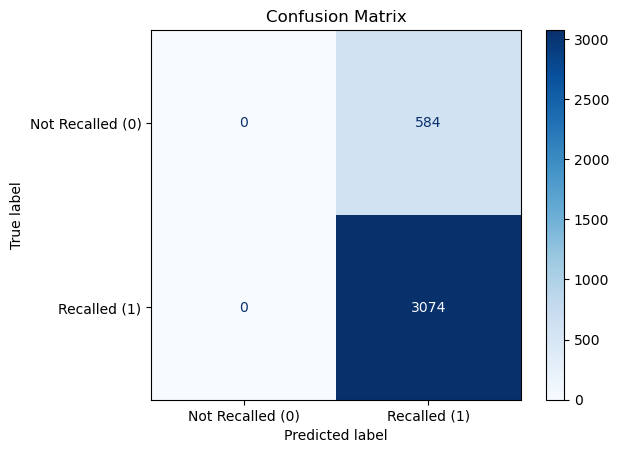

Dummy - F1 Score (No Recall): 0.0000, F1 Score (Recall): 0.9133, Accuracy: 0.8403, Precision (No Recall): 0.0000, Precision (Recall): 1.0000
Training Logistic Regression...


<Figure size 800x600 with 0 Axes>

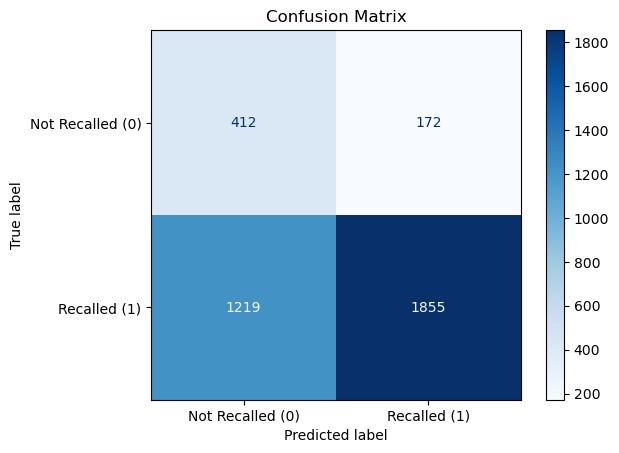

Logistic Regression - F1 Score (No Recall): 0.3720, F1 Score (Recall): 0.7273, Accuracy: 0.6197, Precision (No Recall): 0.7055, Precision (Recall): 0.6034
Training Random Forest...


<Figure size 800x600 with 0 Axes>

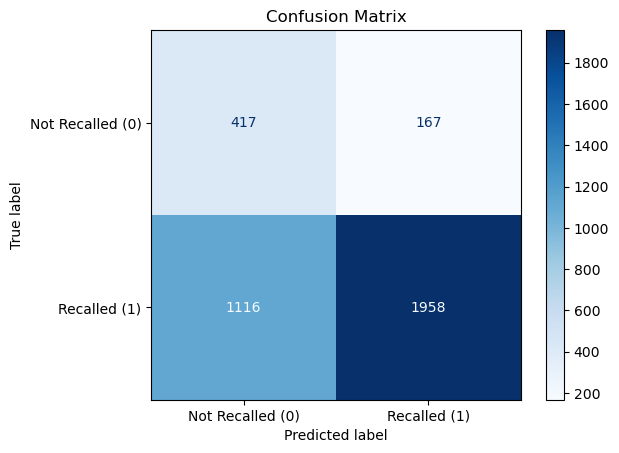

Random Forest - F1 Score (No Recall): 0.3940, F1 Score (Recall): 0.7532, Accuracy: 0.6493, Precision (No Recall): 0.7140, Precision (Recall): 0.6370
Training SVM...


<Figure size 800x600 with 0 Axes>

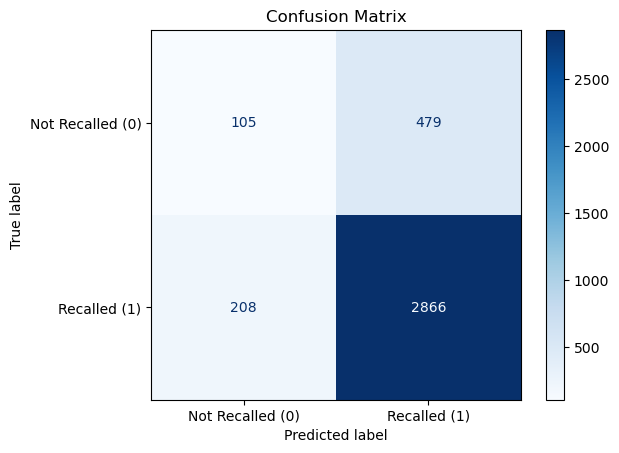

SVM - F1 Score (No Recall): 0.2341, F1 Score (Recall): 0.8930, Accuracy: 0.8122, Precision (No Recall): 0.1798, Precision (Recall): 0.9323


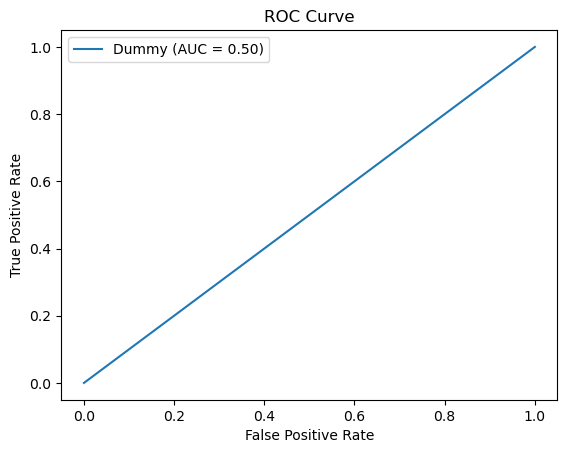

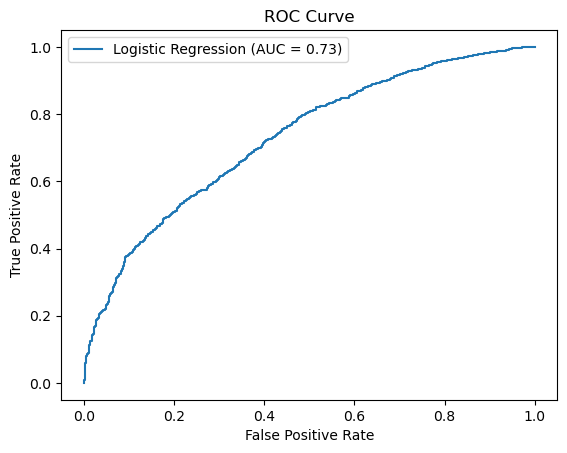

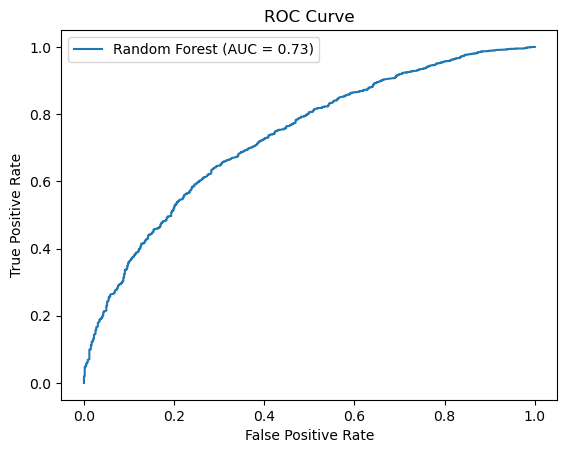

AttributeError: This 'Pipeline' has no attribute 'predict_proba'

In [16]:
X = df.drop(['recalled_bool'], axis=1)
y = df['recalled_bool']

# Using pipelines for scaling and model fitting
models = {
    'Dummy': Pipeline([('scaler', StandardScaler()), ('classifier', DummyClassifier(strategy='most_frequent', random_state=42))]),

    'Logistic Regression': Pipeline([('scaler', StandardScaler()), ('classifier', LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42))]),

    'Random Forest': Pipeline([('scaler', StandardScaler()), ('classifier', RandomForestClassifier(n_estimators=100, max_leaf_nodes=10, bootstrap=False, class_weight='balanced', random_state=42))]),
    
    'SVM': Pipeline([('scaler', StandardScaler()), ('classifier', SVC(C=100, class_weight='balanced', gamma=1, kernel='rbf', random_state=42))])
}

# Dummy classifier for baseline
dummy = DummyClassifier(strategy='most_frequent', random_state=42)

# Logistic regression with class weights (simple model)
lr = LogisticRegression(class_weight='balanced', solver = 'liblinear', random_state= 42)

# Random Forest Classifier
rf = RandomForestClassifier(n_estimators = 100, max_leaf_nodes = 10, bootstrap = False, class_weight = 'balanced', random_state = 42)


# SVM Classifier
svm = SVC(C = 100, class_weight = 'balanced', gamma = 1, kernel = 'rbf', random_state = 42)


# results will hold the cross validation results
results = np.zeros((4, 5))

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for i, (name, model) in enumerate(models.items()):
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    report = classification_report(y_test, y_pred, output_dict=True)
    results[i, 0] = report['0']['f1-score']
    results[i, 1] = report['1']['f1-score']
    results[i, 2] = report['accuracy']
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    results[i, 3] = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0
    results[i, 4] = cm[1, 1] / (cm[1, 0] + cm[1, 1]) if (cm[1, 0] + cm[1, 1]) > 0 else 0
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Recalled (0)', 'Recalled (1)'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()
    
    print(f"{name} - F1 Score (No Recall): {results[i, 0]:.4f}, F1 Score (Recall): {results[i, 1]:.4f}, Accuracy: {results[i, 2]:.4f}, Precision (No Recall): {results[i, 3]:.4f}, Precision (Recall): {results[i, 4]:.4f}")



# For each model, plot ROC curve and calculate AUC
for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()  
